# Clasificación de discursos

En primer lugar se importan las distintas librerias a utilizar

In [1]:
# Librerias básicas para el tratamiento de datos
import pandas as pd
import numpy as np

# Se utiliza para el tratamiento de los textos
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.util import ngrams
from nltk.stem import SnowballStemmer

# Se utiliza para obtener distintos signos de puntuación
from string import punctuation

# Distintos vectorizadores
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Se utilizan en la selección y evaluación de los modelos
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Los distintos modelos utilizados
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Librerías para la representación gráfica de los resultados
import matplotlib.pyplot as plt
import seaborn as sns

### Crear_df

Crea un dataframe donde cada fila contiene un discurso, la persona que lo emitio, su partido y su ideología. El tratamiento es similar al del análisis_parlamento.

In [2]:
def crear_df(filename, presi = False):
    with open(filename,"r", encoding="utf8") as file:
        lines = file.read()    

    lines = lines.split("\n")
    
    document = []
    line_erasers = ["LENO","\x0c","úm. 14","XI LEGISLATURA","DSPA_11_014","Pág.","2 de mayo de 2019","11-19/CAU-000001","11-19"]
    take_out_words = ["\n","—","PLENO"]

    for l in lines:
        insert = True
        for word in take_out_words:
            l = l.replace(word,"")
        for eraser in line_erasers:
            if eraser in l:
                insert = False
        if insert:
            document.append(l)
        
    d = {'texto': [], 'nombre': [], 'partido': [], 'ideologia': [], 'ntoken': []}

    df = pd.read_csv("partidos.csv",delimiter=";")

    key = ""
    i = 0
    texto = ""
    no_dialogo = True
    persona = ""
    inicio = None
    fin = None
    for n_pag,line in enumerate(document):
        if ("El señor" in line or "La señora" in line) and sum(map(str.isupper,line)) > 9 and sum(map(str.islower,line)) < 10:
            dialogo = True
            i+=1
            if i == 1:
                persona = line.strip("La señora ").strip("El señor ")
                persona = persona.split(",")
                if type(persona) == list:
                    persona = persona[0]
                inicio = n_pag
            else:
                fin = n_pag-1
                if (presi or persona != 'BOSQUET AZNAR'):
                    d['nombre'].append(persona)
                    d['texto'].append(texto)
                    d['ntoken'].append(len(texto.split(' ')))
                    d['partido'].append(df[df['persona'] == persona]['partido'].iloc[0])
                    d['ideologia'].append(df[df['persona'] == persona]['ideologia'].iloc[0])
    #             intervencion = Intervencion(persona,inicio,texto,fin)
                persona = line.strip("La señora ").strip("El señor ")
                persona = persona.split(",")
                if type(persona) == list:
                    persona = persona[0]
                if "ÓPEZ" == persona[0:4]:
                    persona = "L"+persona
                if "SPINOSA" == persona[0:7]:
                    persona = "E"+persona
                if "RAMIREZ DE ARELLANO" in persona:
                    persona = "RAMÍREZ DE ARELLANO"
                if "RAMÍREZ DE ARELLANO LÓPEZ" in persona:
                    persona = "RAMÍREZ DE ARELLANO"
                if "MORA GRAND" == persona:
                    persona = "MORA GRANDE"
                if "FERRIZ GOMEZ" == persona:
                    persona = "FÉRRIZ GÓMEZ"
                if "SEGOVIA BROM" == persona:
                    persona = "SEGOVIA BROME"
                if "OPIS" == persona[0:4]:
                    persona = "LL" + persona
                    
                inicio = n_pag
                texto = ""
    #             if not intervencion.persona in intervenciones.keys():
    #                 intervenciones[intervencion.persona] = [intervencion]
    #             else:
    #                 intervenciones[intervencion.persona].append(intervencion)
        else:
            if i > 0:
                if "11-19/DL-000001" in line or "DVOT-000012" in line:
                    dialogo = False
                if dialogo:
                    texto+=line + " "
                    
    return pd.DataFrame(data=d)

### getVectorize

Obtiene el vectorizador correspondiente según los parámetros indicados. El vectorizador, transforma el texto en una matriz de números que provienen de los tokens generados en la vectorización. Es un paso crucial del proceso.

In [3]:
def getVectorize(stemmer = False, nGram = 2, stopWords = True):
    if stopWords:
        spanish_stopwords = stopwords.words('spanish')
    else:
        spanish_stopwords = []
        
    non_words = list(punctuation)
    non_words.extend(['¿', '¡'])
    non_words.extend(map(str,range(10)))

    def tokenize(text):
        text = ''.join([c for c in text if c not in non_words])
        tokens =  word_tokenize(text)
            
        s = []
        for n in range(1,nGram+1):
            for ngram in ngrams(tokens, n):
                s.append(' '.join(str(i) for i in ngram))

        return s
    
    if stemmer:
        stemmer = SnowballStemmer('spanish')
        analyzer = CountVectorizer().build_analyzer()

        def stemmed_words(doc):
            return (stemmer.stem(w) for w in analyzer(doc))
        
        return CountVectorizer(
                    analyzer = stemmed_words,
                    tokenizer = tokenize,
                    lowercase = True,
                    stop_words = spanish_stopwords)

    return CountVectorizer(
                    analyzer = 'word',
                    tokenizer = tokenize,
                    lowercase = True,
                    stop_words = spanish_stopwords)

### clasifyScore

Entrena los distintos modelos con un 75% de los datos y los evalua con el 25% restante para dar una puntuación. Además de las puntuaciones devuelve los modelos entrenados.

In [4]:
def clasifyScore(X, y):
    scores = []
    models = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = MultinomialNB().fit(X_train, y_train)
    models.append(clf)
    scores.append(clf.score(X_test, y_test))
    clf = GaussianNB().fit(X_train.todense(), y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = KNeighborsClassifier(n_neighbors = 8).fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = SVC(kernel = 'linear').fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0
                                ).fit(X_train, y_train) 
    models.append(clf)
    scores.append(clf.score(X_test.todense(), y_test))
    
    return scores, models

### getXdata

Se obtiene la matriz X con la que se alimentarán los modelos así como los datos originales. También se puede devolver el vectorizador usado.

In [5]:
def getXdata(metodo, ntoken = 0, stopWords = True, presi=False, vecto=False):
    data = crear_df('sumtext.txt', presi)
    data = data[data['ntoken']>=ntoken]
    
    if (metodo == 'Tf-idf'):
        counts = TfidfVectorizer().fit_transform(data['texto'])
    elif (metodo == 'Unigramas'):
        vectorizer = getVectorize(nGram = 1, stopWords=stopWords)
        counts = vectorizer.fit_transform(data['texto'])
    elif (metodo == 'Bigramas'):
        vectorizer = getVectorize(nGram = 2, stopWords=stopWords)
        counts = vectorizer.fit_transform(data['texto'])
    elif (metodo == 'Trigramas'):
        vectorizer = getVectorize(nGram = 3, stopWords=stopWords)
        counts = vectorizer.fit_transform(data['texto'])
    else:
        return []
    
    if vecto:
        return counts, data, vectorizer
        
    return counts, data

### getScores

Utiliza clasifyScore para guardar en los diccionarios d y dm los datos y los modelos de datos de las tres características.

In [6]:
def getScores(d, dm, metodo, ntoken = 0, stopWords = True, presi=False):
    X, data = getXdata(metodo, ntoken, stopWords, presi)
    
    if ((not stopWords) and (metodo != 'Tf-idf')) :
        metodo += ' con stopwords'
    
    d['Nombre'][metodo], dm['Nombre'][metodo] = clasifyScore(X, data['nombre'])
    d['Partido'][metodo], dm['Partido'][metodo] = clasifyScore(X, data['partido'])
    d['Ideologia'][metodo], dm['Ideologia'][metodo] = clasifyScore(X, data['ideologia'])

### plotMetodo

Se representa una matriz con mapa de calor con los distintos métodos de vectorización en el eje Y así como los métodos de entrenamiento en el eje X.

In [7]:
def plotMetodo(d, caract, presi=False, ntoken=0):
    labels = ["MultinomialNB", "GaussianNB" ,"KNeighbors" ,"DecisionTree"
                  ,"LinearSVC" ,"RandomForest"]
    df = pd.DataFrame(data = d[caract], index=labels).T
    sns.heatmap(df,cmap="RdYlBu", linewidths=0.5, vmin=0, vmax =1, annot=True)
    plt.yticks(rotation=0) 
    title = 'Aciertos en el Clasificador de ' + caract + 's con ntoken='+str(ntoken)
    if presi:
        title += ' con president@'
    plt.title(title)
    plt.show()

### plotAll

Realiza todo el proceso para todos las características, modelos de vectorización y entrenamiento.

In [8]:
def plotAll(presi=False, ntoken=0, stopwords=False):
    d ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
    dm ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
    
    
    %time getScores(d, dm, 'Tf-idf', presi=presi, ntoken=ntoken)
    %time getScores(d, dm, 'Unigramas', presi=presi, ntoken=ntoken)
    %time getScores(d, dm, 'Bigramas', presi=presi, ntoken=ntoken)
    %time getScores(d, dm, 'Trigramas', presi=presi, ntoken=ntoken)
    
    if stopwords:
        %time getScores(d, dm, 'Unigramas', stopWords=False, presi=presi, ntoken=ntoken)
        %time getScores(d, dm, 'Bigramas', stopWords=False, presi=presi, ntoken=ntoken)
        %time getScores(d, dm, 'Trigramas', stopWords=False, presi=presi, ntoken=ntoken)

    plotMetodo(d,'Nombre', presi=presi, ntoken=ntoken)
    plotMetodo(d,'Partido', presi=presi, ntoken=ntoken)
    plotMetodo(d,'Ideologia', presi=presi, ntoken=ntoken)
    
    return dm

En primer lugar se ponen los parámetro por defecto.

CPU times: user 3.65 s, sys: 864 ms, total: 4.51 s
Wall time: 4.86 s
CPU times: user 5.13 s, sys: 152 ms, total: 5.28 s
Wall time: 5.41 s
CPU times: user 19.1 s, sys: 7.66 s, total: 26.8 s
Wall time: 26.8 s
CPU times: user 45.4 s, sys: 20.6 s, total: 1min 5s
Wall time: 1min 5s


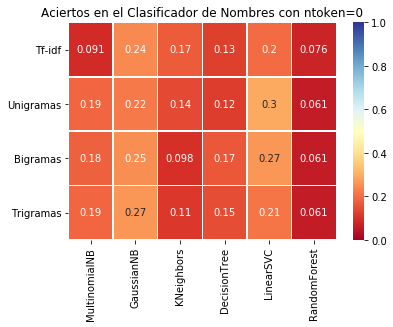

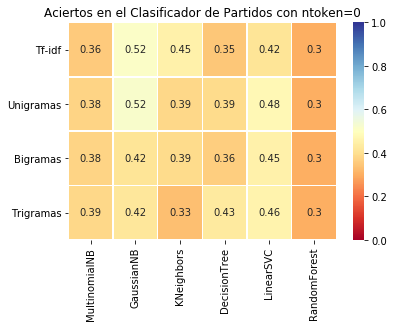

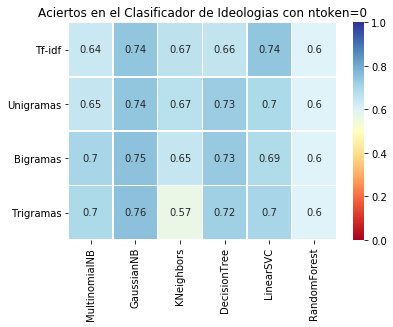

In [9]:
dm = plotAll()

Se prueban distintos valores de ntoken encontrando mejores resultados con ntoken=20

CPU times: user 3.31 s, sys: 117 ms, total: 3.43 s
Wall time: 3.41 s
CPU times: user 5.39 s, sys: 114 ms, total: 5.5 s
Wall time: 5.46 s
CPU times: user 15.5 s, sys: 5.41 s, total: 20.9 s
Wall time: 20.9 s
CPU times: user 37 s, sys: 15.6 s, total: 52.7 s
Wall time: 52.6 s


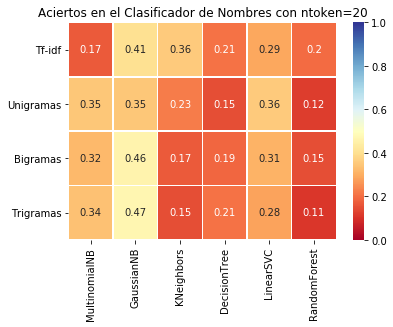

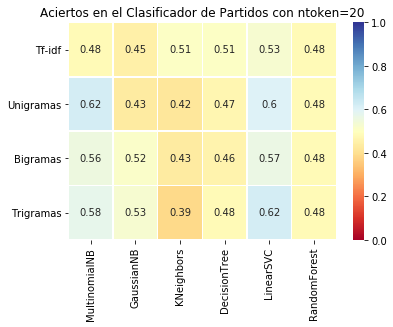

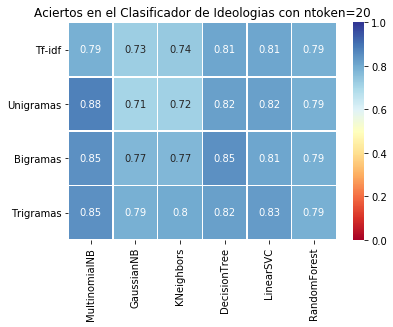

In [10]:
dm = plotAll(ntoken=20)

Se comprueba que, en general, al quitar las stopwords se mejoran los resultados. En los casos en los que no mejora cabe destacar que al quitarlas mejora el rendimiento en cuanto a tiempo se refiere y las diferencias son pequeñas.

CPU times: user 3.37 s, sys: 32.7 ms, total: 3.41 s
Wall time: 3.37 s
CPU times: user 5.28 s, sys: 28 ms, total: 5.3 s
Wall time: 5.27 s
CPU times: user 15.8 s, sys: 5.77 s, total: 21.5 s
Wall time: 21.5 s
CPU times: user 35.5 s, sys: 14.8 s, total: 50.3 s
Wall time: 50.3 s
CPU times: user 4.94 s, sys: 104 ms, total: 5.04 s
Wall time: 5.01 s
CPU times: user 15.3 s, sys: 5.59 s, total: 20.9 s
Wall time: 20.8 s
CPU times: user 36.4 s, sys: 15.4 s, total: 51.8 s
Wall time: 1min 37s


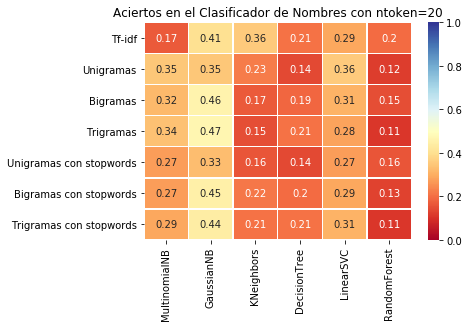

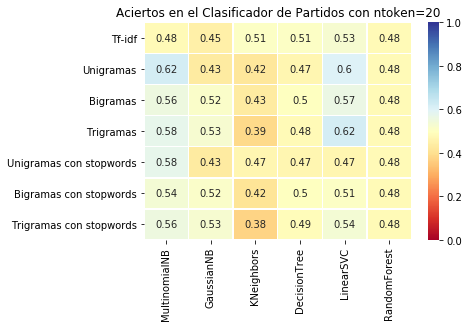

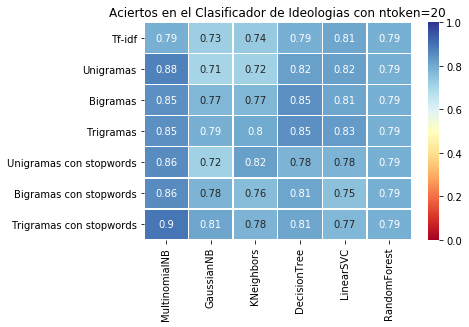

In [11]:
dm = plotAll(ntoken=20, stopwords=True)

### getRelevantes

Obtiene los tokens más relevantes del modelo MultinomialNB a modo anecdótico.

In [12]:
def getRelevantes(vectorizer, clf, modelo, n=20):
    if modelo == "MultinomialNB":
        feature_names = vectorizer.get_feature_names()
        coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
        top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
        print("%-23s   %-23s" % ('Términos menos relvantes', 'Términos más relvantes'))
        print()
        for (coef_1, fn_1), (coef_2, fn_2) in top:
            print("%.4f  %-15s  %.4f  %-15s" % (coef_1, fn_1, coef_2, fn_2))

### confMatrix

Muestra la matriz de confusión así como los términos más relevantes en el caso del modelo MultinomialNB.

In [13]:
def confMatrix(caract, metodo, modelo, dm = {}, ntoken=20):
    if not dm:
        d ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
        dm ={'Nombre': {}, 'Partido': {}, 'Ideologia': {}}
        getScores(d, dm, metodo, ntoken=ntoken)
        
    labels = ["MultinomialNB", "GaussianNB" ,"KNeighbors" ,"DecisionTree"
                  ,"LinearSVC" ,"RandomForest"]
    
    X, data, vectorizer = getXdata(metodo, ntoken=ntoken, vecto=True)
    
    clf = dm[caract][metodo][labels.index(modelo)]
    X_train, X_test, y_train, y_test = train_test_split(X, data[caract.lower()], random_state=0)
    
    getRelevantes(vectorizer, clf, modelo)
    
    y_pred = clf.predict(X_test)
    labels= list(set(data[caract.lower()]))
    conf_mat = confusion_matrix(y_test.tolist(), y_pred.tolist(),labels )
    sns.heatmap(conf_mat, linewidths=0.5, fmt='g', annot=True, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predición')
    plt.ylabel('Test')
    plt.title('Matriz de confusión para '+caract+'s con '+metodo+', '+modelo+' y ntoken='+str(ntoken))

Como se obtuvieron resultados decentes con la característica partido se muestra la matriz de confusión. Cabe destacar que los errores pueden mostrar relaciones relevantes entre partidos.

Términos menos relvantes   Términos más relvantes 

-10.3477  abanderamos      -5.3304  ustedes        
-10.3477  abanderarlo      -5.4350  andalucía      
-10.3477  abandonada       -5.6843  ley            
-10.3477  abandonan        -5.7227  si             
-10.3477  abandonar        -5.7425  gobierno       
-10.3477  abandonen        -6.0436  ser            
-10.3477  abarca           -6.0850  usted          
-10.3477  abarque          -6.1282  va             
-10.3477  abascal          -6.2046  aquí           
-10.3477  abastecimientos  -6.2206  solo           
-10.3477  abc              -6.2206  además         
-10.3477  aberraciones     -6.2533  señora         
-10.3477  abiertos         -6.2533  gracias        
-10.3477  abismal          -6.3046  sector         
-10.3477  abismo           -6.3046  partido        
-10.3477  abocada          -6.3223  muchas         
-10.3477  abocadas         -6.3587  sistema        
-10.3477  abocado          -6.3774  personas       
-10.3477  ab

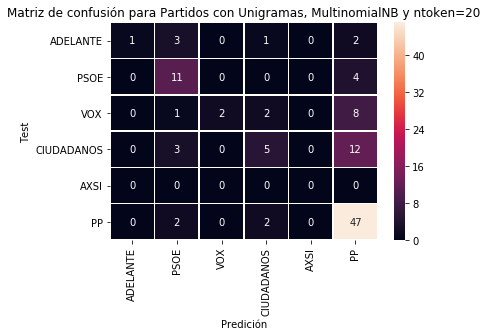

In [14]:
confMatrix('Partido','Unigramas', "MultinomialNB", dm)

Se estudia el caso de las ideologías en el que se muestra un comportamiento inesperadamente bueno. Con estos resultados se puede concluir que se puede clasificar de forma significativa los discursos según su ideología.

Términos menos relvantes   Términos más relvantes 

-10.8710  abanderarlo      -4.8331  andalucía      
-10.8710  abandonada       -4.8427  ustedes        
-10.8710  abandonan        -5.0188  gobierno       
-10.8710  abandonen        -5.1806  usted          
-10.8710  abarque          -5.4286  si             
-10.8710  abc              -5.4683  señor          
-10.8710  aberraciones     -5.4728  ley            
-10.8710  abismal          -5.6949  partido        
-10.8710  abismo           -5.7711  grupo          
-10.8710  abocada          -5.8738  gracias        
-10.8710  abogacía         -5.8874  aquí           
-10.8710  abonada          -5.9012  ser            
-10.8710  abonado          -5.9152  personas       
-10.8710  abone            -5.9152  años           
-10.8710  abonó            -5.9294  señora         
-10.8710  abor             -5.9510  socialista     
-10.8710  aborda           -5.9807  va             
-10.8710  abordada         -6.0035  además         
-10.8710  ab

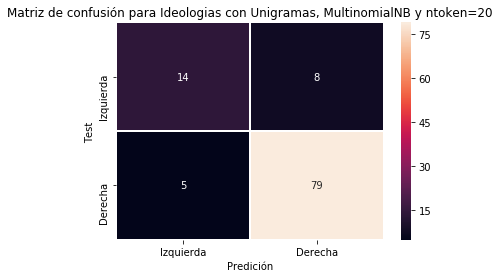

In [15]:
confMatrix('Ideologia','Unigramas', "MultinomialNB", dm)

Finalmente se muestra que con Trigramas el modelo no mejora significativamente para la carga computacional que implica.

Términos menos relvantes   Términos más relvantes 

-13.1742  a a              -6.7397  de la          
-13.1742  a a esa          -7.1364  andalucía      
-13.1742  a abandonar      -7.1460  ustedes        
-13.1742  a abandonar sus  -7.3220  gobierno       
-13.1742  a abandonar una  -7.4312  de los         
-13.1742  a abordar        -7.4377  en el          
-13.1742  a abordar enfocándola  -7.4507  lo que         
-13.1742  a abordar enmiendas  -7.4839  usted          
-13.1742  a abordar la     -7.5359  que se         
-13.1742  a abordar vamos  -7.6408  a la           
-13.1742  a abordarlo      -7.6689  en la          
-13.1742  a abordarlo todo  -7.6853  que no         
-13.1742  a abrir al       -7.7318  si             
-13.1742  a abrir qué      -7.7493  de las         
-13.1742  a acabar pues    -7.7716  señor          
-13.1742  a acabar todos   -7.7761  ley            
-13.1742  a aceptar de     -7.9593  a los          
-13.1742  a aceptar estas  -7.9981  partido        
-

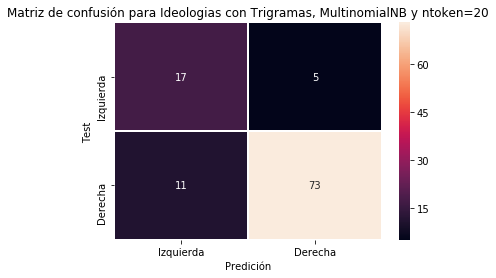

In [16]:
confMatrix('Ideologia','Trigramas', "MultinomialNB", dm)